In [ ]:
import zipfile
import os

zip_path = "/content/images.zip"
extract_path = "/content/images/images/images/images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path)
print("Total images:", len(os.listdir(extract_path)))

Extracted to: /content/images/images/images/images
Total images: 7394


In [ ]:
import pandas as pd

list_file = "/content/list.txt"
train_file = "/content/trainval.txt"
test_file = "/content/test.txt"

df = pd.read_csv(list_file, sep=" ", comment="#", header=None,
                 names=["image_id", "class_id", "species", "breed_id"])

print("Total records in list.txt:", len(df))
df.head()

Total records in list.txt: 7349


,image_id,class_id,species,breed_id
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [ ]:
print("Unique Classes:", df['class_id'].nunique())
print("Unique Species:", df['species'].unique())  # 1 = Cat, 2 = Dog
print("Breed IDs:", df['breed_id'].unique())

print(df['species'].value_counts())

Unique Classes: 37
Unique Species: [1 2]
Breed IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
species
2    4978
1    2371
Name: count, dtype: int64


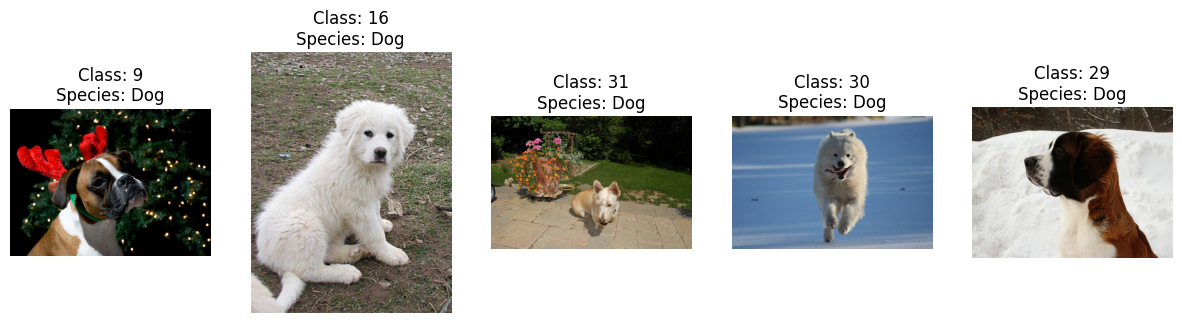

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

images_path = "/content/images/images/images/images"

samples = df.sample(5)

plt.figure(figsize=(15, 8))
for i, row in enumerate(samples.itertuples()):
    img_path = os.path.join(images_path, row.image_id + ".jpg")
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Class: {row.class_id}\nSpecies: {'Cat' if row.species==1 else 'Dog'}")
    plt.axis("off")

plt.show()

In [ ]:
def load_split(file_path):
    df_split = pd.read_csv(file_path, sep=" ", header=None, comment="#",
                           names=["image_id", "class_id", "species", "breed_id"])
    return df_split

train_df = load_split(train_file)
test_df = load_split(test_file)

print("Train images:", len(train_df))
print("Test images:", len(test_df))

Train images: 3680
Test images: 3669


In [ ]:
print("Train species counts:")
print(train_df['species'].value_counts())

print("\nTest species counts:")
print(test_df['species'].value_counts())

Train species counts:
species
2    2492
1    1188
Name: count, dtype: int64

Test species counts:
species
2    2486
1    1183
Name: count, dtype: int64


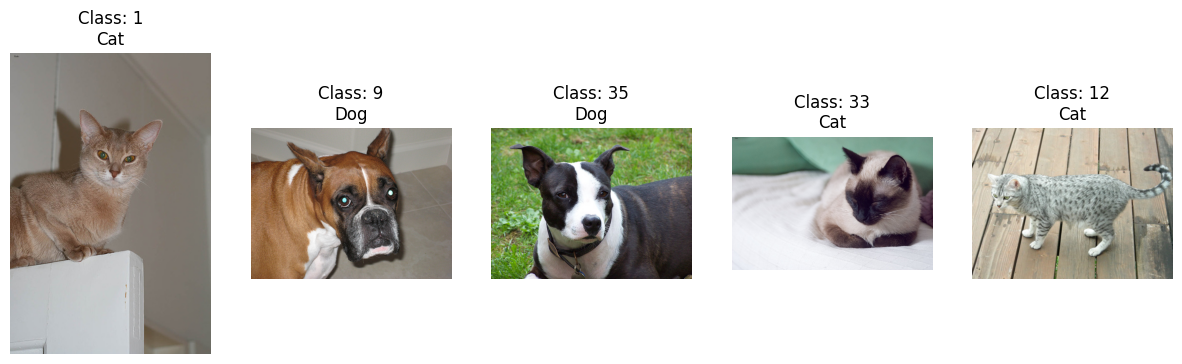

In [ ]:
import cv2
import os
import random

images_path = "/content/images/images/images/images"

def show_samples(df, n=5):
    samples = df.sample(n)
    plt.figure(figsize=(15, 8))

    for i, row in enumerate(samples.itertuples()):
        img_path = os.path.join(images_path, row.image_id + ".jpg")
        if not os.path.exists(img_path):
            img_path = os.path.join(images_path, row.image_id + ".JPG")

        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Class: {row.class_id}\n{'Cat' if row.species==1 else 'Dog'}")
        plt.axis("off")
    plt.show()

show_samples(train_df, 5)

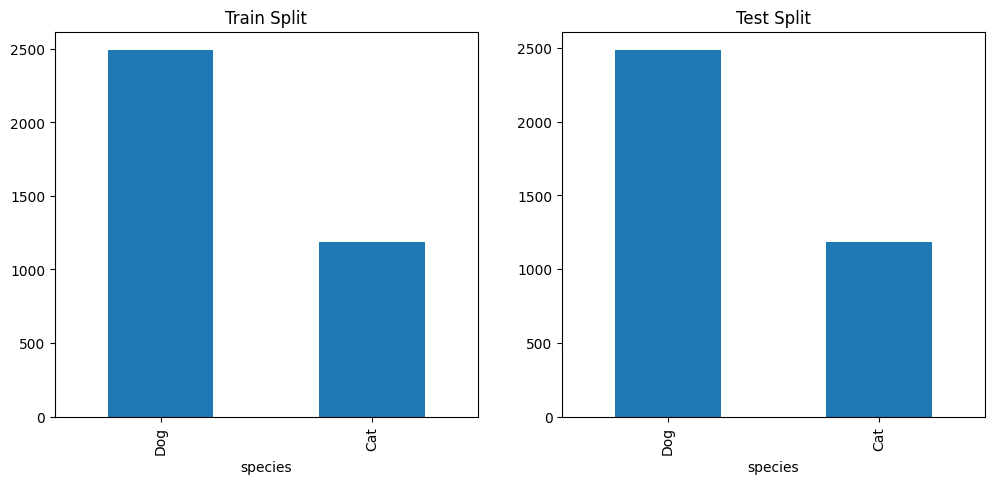

In [ ]:
import matplotlib.pyplot as plt

species_map = {1: "Cat", 2: "Dog"}

train_species_counts = train_df['species'].map(species_map).value_counts()
test_species_counts = test_df['species'].map(species_map).value_counts()

fig, ax = plt.subplots(1, 2, figsize=(12,5))

train_species_counts.plot(kind="bar", ax=ax[0], title="Train Split")
test_species_counts.plot(kind="bar", ax=ax[1], title="Test Split")

plt.show()

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import cv2

class PetsDataset(Dataset):
    def __init__(self, df, images_path, transform=None):
        self.df = df.reset_index(drop=True)
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.images_path, row.image_id + ".jpg")


        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)


        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = row.class_id - 1
        return img, label


In [ ]:
# DATA AUGMENTATION

import torch
from torchvision import transforms as T

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def build_transforms(img_size: int = 160, aug_strength: str = "medium"):
    """
    Create torchvision transforms for training and validation.
    aug_strength: "light" | "medium" | "heavy"
    """

    if aug_strength == "light":
        train_augs = [
            T.RandomResizedCrop(img_size, scale=(0.85, 1.0), ratio=(0.8, 1.25)),
            T.RandomHorizontalFlip(p=0.5),
        ]
    elif aug_strength == "heavy":
        train_augs = [
            T.RandomResizedCrop(img_size, scale=(0.6, 1.0), ratio=(0.75, 1.33)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=20),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
            T.RandomPerspective(distortion_scale=0.2, p=0.25),
        ]
    else:
        train_augs = [
            T.RandomResizedCrop(img_size, scale=(0.7, 1.0), ratio=(0.75, 1.33)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=15),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.03),
            T.RandomPerspective(distortion_scale=0.15, p=0.2),
        ]

    train_tfms = T.Compose(
        train_augs
        + [
            T.ToTensor(),
            T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
            T.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3), value='random'),
        ]
    )


    valid_tfms = T.Compose([
        T.Resize(int(img_size * 1.14)),
        T.CenterCrop(img_size),
        T.ToTensor(),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    return train_tfms, valid_tfms

train_tfms, valid_tfms = build_transforms(img_size=160, aug_strength="medium")
#print(train_tfms)
#print(valid_tfms)


In [ ]:
# DATASET & DATALOADER ,AUG VISUALIZATION

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

images_path = "/content/images/images/images/images"

class PetsDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row.image_id + ".jpg")
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, row.image_id + ".JPG")
        image = Image.open(img_path).convert("RGB")
        label = row.class_id - 1  # class_id starts from 1 → shift to 0
        if self.transform:
            image = self.transform(image)
        return image, label


# Build datasets
train_ds = PetsDataset(train_df, images_path, transform=train_tfms)
valid_ds = PetsDataset(test_df, images_path, transform=valid_tfms)

# Counts
#print(f"Train size: {len(train_ds)}")
#print(f"Valid/Test size: {len(valid_ds)}")

# DataLoaders (batch size can be tuned)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=False, num_workers=2)


In [ ]:
# Visualize some augmented images
# import matplotlib.pyplot as plt
# import numpy as np
# def show_augmented_images(dataset, n=6):
#     fig, axs = plt.subplots(1, n, figsize=(18, 4))
#     for i in range(n):
#         img, label = dataset[random.randint(0, len(dataset)-1)]

#         img_np = img.permute(1, 2, 0).cpu().numpy()

#         img_np = img_np * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
#         img_np = img_np.clip(0,1)
#         axs[i].imshow(img_np)
#         axs[i].set_title(f"Class {label+1}")
#         axs[i].axis("off")
#     plt.show()

# Show some training augmentations
#show_augmented_images(train_ds, n=6)

In [ ]:
# PREPROCESSING FUNCTION

def preprocess_images(train_df, test_df, images_path, img_size=160, aug_strength="medium"):
    """
    Prepares training & validation datasets and dataloaders.

    Args:
        train_df (pd.DataFrame): dataframe with training split
        test_df (pd.DataFrame): dataframe with test split
        images_path (str): path to images folder
        img_size (int): resize/crop size (default 224 for VGG/ViT)
        aug_strength (str): 'light' | 'medium' | 'heavy' (data augmentation)

    Returns:
        train_loader, valid_loader, class_count
    """
    # Build transforms
    train_tfms, valid_tfms = build_transforms(img_size=img_size, aug_strength=aug_strength)

    # Build datasets
    train_ds = PetsDataset(train_df, images_path, transform=train_tfms)
    valid_ds = PetsDataset(test_df, images_path, transform=valid_tfms)

    # Build dataloaders
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False, num_workers=2)

    # Number of classes
    num_classes = train_df['class_id'].nunique()

    print(f"Preprocessing complete")
    print(f"Train size: {len(train_ds)} images")
    print(f"Valid/Test size: {len(valid_ds)} images")
    print(f"Number of classes: {num_classes}")

    return train_loader, valid_loader, num_classes


# Run preprocessing
# train_loader, valid_loader, num_classes = preprocess_images(
#     train_df, test_df, images_path, img_size=160, aug_strength="medium"
# )


In [ ]:
# VGG MODEL

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

def train_vgg_model(train_loader, valid_loader, num_classes, epochs=5, lr=1e-4, device="cuda"):
    """
    Builds, trains, and validates a lightweight VGG16 model on Oxford-IIIT Pet dataset.
    Freezes conv layers to avoid GPU crash.
    """
    # 1. Build VGG model
    model = models.vgg16(pretrained=True)

    # Freeze convolutional layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace classifier
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
    model = model.to(device)

    # 2. Loss & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    # 3. Track metrics
    history = {"train_loss": [], "valid_loss": [], "train_acc": [], "valid_acc": []}

    # 4. Training loop
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        valid_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in valid_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * imgs.size(0)
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

        avg_valid_loss = valid_loss / total
        valid_acc = correct / total

        # Save history
        history["train_loss"].append(avg_train_loss)
        history["valid_loss"].append(avg_valid_loss)
        history["train_acc"].append(train_acc)
        history["valid_acc"].append(valid_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} "
              f"Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

    return model, history

In [ ]:
# ==== MODEL EVALUATION ====
def evaluate_model(model, dataloader, history=None, device="cuda", class_names=None, plot_cm=True):
    """
    Evaluate a trained model on a dataloader + show training curves.

    Args:
        model (nn.Module): trained model
        dataloader (DataLoader): validation/test dataloader
        history (dict): training history containing loss/accuracy (optional)
        device (str): 'cuda' or 'cpu'
        class_names (list): list of class names (optional)
        plot_cm (bool): whether to plot confusion matrix

    Returns:
        metrics (dict): accuracy, classification report
    """
    model.eval()
    all_labels = []
    all_preds = []
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"\n✅ Evaluation Accuracy: {acc:.4f}")

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names if class_names else None)
    print(report)

    # Confusion Matrix
    if plot_cm:
      cm = confusion_matrix(all_labels, all_preds)
      plt.figure(figsize=(10,8))
      sns.heatmap(
          cm, annot=True, fmt="d", cmap="Blues",
          xticklabels=class_names if class_names is not None else range(cm.shape[1]),
          yticklabels=class_names if class_names is not None else range(cm.shape[0]))
      plt.xlabel("Predicted")
      plt.ylabel("True")
      plt.title("Confusion Matrix")
      plt.show()

    # Training curves
    if history is not None:
        epochs = range(1, len(history["train_loss"]) + 1)

        plt.figure(figsize=(14,5))

        # --- Loss ---
        plt.subplot(1,2,1)
        plt.plot(epochs, history["train_loss"], label="Train Loss")
        plt.plot(epochs, history["valid_loss"], label="Valid Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()

        # --- Accuracy ---
        plt.subplot(1,2,2)
        plt.plot(epochs, history["train_acc"], label="Train Acc")
        plt.plot(epochs, history["valid_acc"], label="Valid Acc")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training vs Validation Accuracy")
        plt.legend()

        plt.show()

    return {"accuracy": acc, "report": report}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

def train_vit_model(train_loader, valid_loader, num_classes, epochs=5, lr=1e-4, device="cuda"):
    """
    Builds, trains, and validates a ViT model on Oxford-IIIT Pet dataset.
    Freezes encoder layers to save compute and only trains the classifier head.
    """
    # 1. Build ViT model
    model = models.vit_b_16(pretrained=True)   # Base ViT-16
    for param in model.parameters():
        param.requires_grad = False  # freeze encoder

    # Replace classifier (head)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)
    model = model.to(device)

    # 2. Loss & optimizer (only classifier parameters will update)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.heads.parameters(), lr=lr)

    # 3. Track metrics
    history = {"train_loss": [], "valid_loss": [], "train_acc": [], "valid_acc": []}

    # 4. Training loop
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        valid_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in valid_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * imgs.size(0)
                _, preds = outputs.max(1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

        avg_valid_loss = valid_loss / total
        valid_acc = correct / total

        # Save history
        history["train_loss"].append(avg_train_loss)
        history["valid_loss"].append(avg_valid_loss)
        history["train_acc"].append(train_acc)
        history["valid_acc"].append(valid_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} "
              f"Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

    return model, history

#train_loader_vit, valid_loader_vit, _ = preprocess_images(train_df, test_df, images_path, img_size=224, aug_strength="medium")
#vit_model, vit_history = train_vit_model(train_loader_vit, valid_loader_vit, num_classes, epochs=5, lr=1e-4, device="cuda")
#vit_results = evaluate_model(vit_model, valid_loader_vit, history=vit_history, device="cuda")

Using device: cuda
Train images: 3680
Test images: 3669

 Showing raw samples...


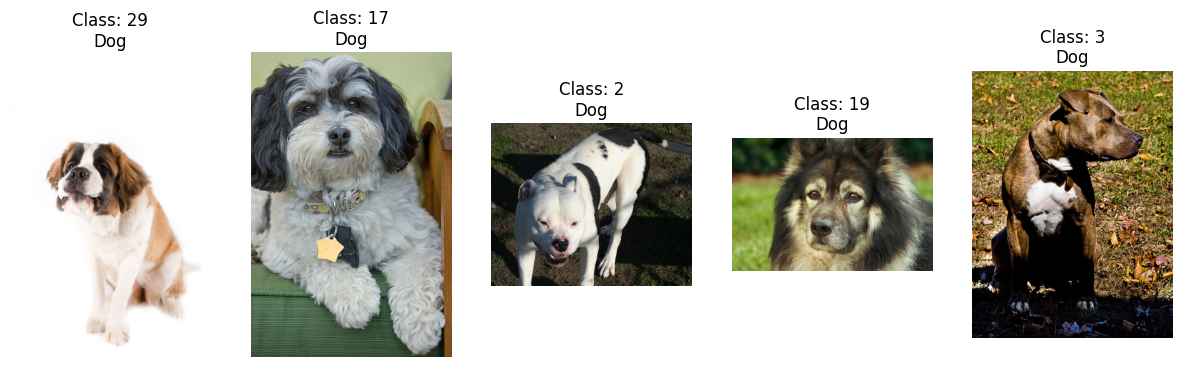


 Preprocessing for VGG (160x160)...
Preprocessing complete
Train size: 3680 images
Valid/Test size: 3669 images
Number of classes: 37

 Preprocessing for ViT (224x224)...
Preprocessing complete
Train size: 3680 images
Valid/Test size: 3669 images
Number of classes: 37

 Showing augmented samples...


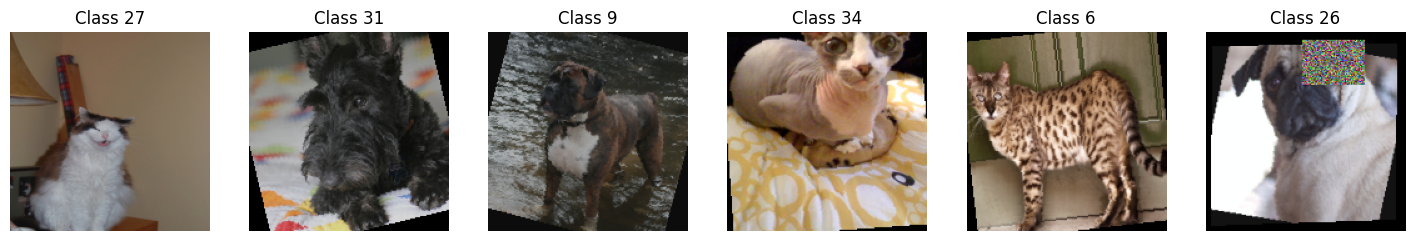


 Training VGG model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 124MB/s]


Epoch [1/5] Train Loss: 1.4623, Train Acc: 0.5764 Valid Loss: 0.4554, Valid Acc: 0.8517
Epoch [2/5] Train Loss: 0.8033, Train Acc: 0.7497 Valid Loss: 0.3904, Valid Acc: 0.8722
Epoch [3/5] Train Loss: 0.6561, Train Acc: 0.7883 Valid Loss: 0.4080, Valid Acc: 0.8626
Epoch [4/5] Train Loss: 0.5490, Train Acc: 0.8277 Valid Loss: 0.4268, Valid Acc: 0.8662
Epoch [5/5] Train Loss: 0.5529, Train Acc: 0.8228 Valid Loss: 0.3665, Valid Acc: 0.8806

 Evaluating VGG model...

✅ Evaluation Accuracy: 0.8806
              precision    recall  f1-score   support

           0       0.92      0.69      0.79        98
           1       0.80      0.84      0.82       100
           2       0.69      0.59      0.64       100
           3       0.97      0.85      0.90       100
           4       0.80      0.92      0.86       100
           5       0.62      0.97      0.76       100
           6       0.76      0.82      0.79       100
           7       0.89      0.95      0.92        88
           8    

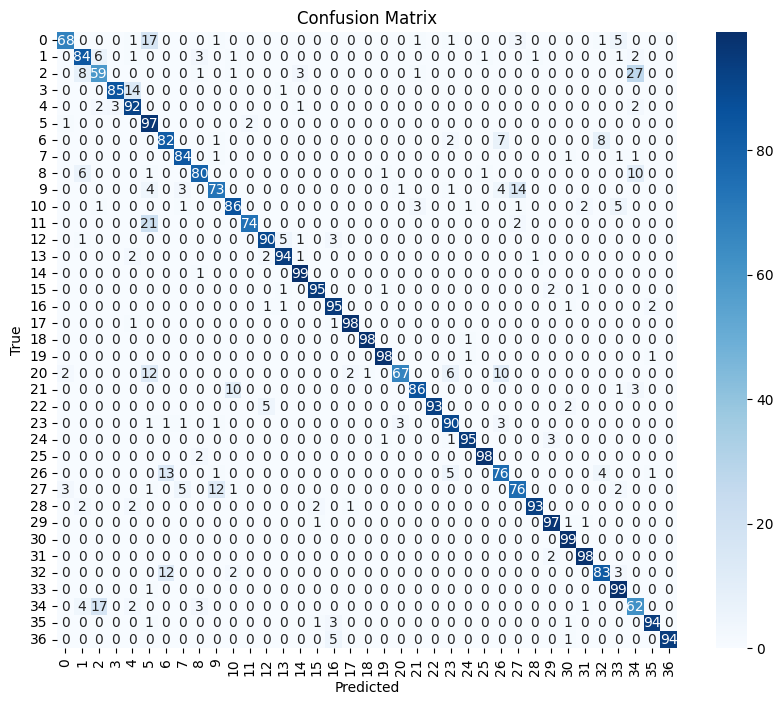

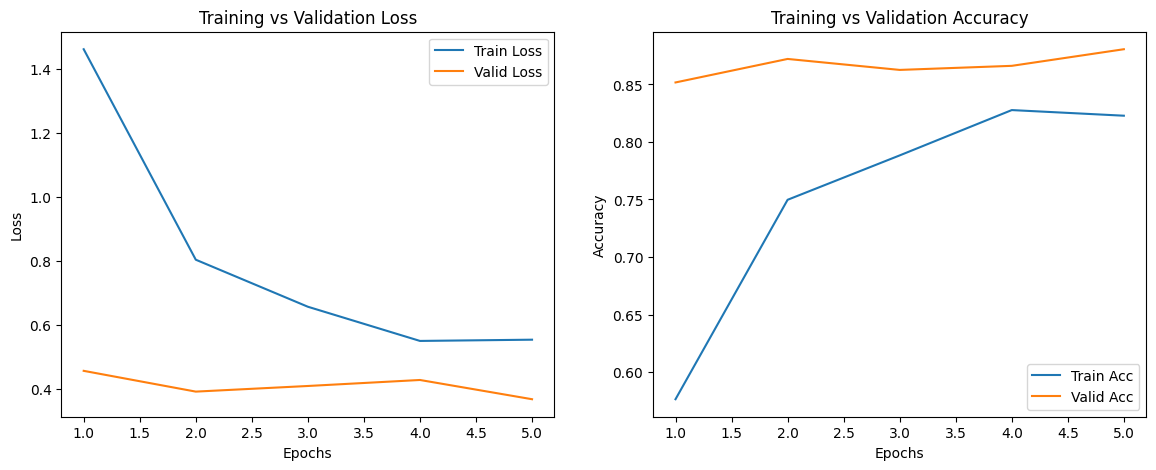


 Training ViT model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 134MB/s]


Epoch [1/5] Train Loss: 3.0497, Train Acc: 0.3908 Valid Loss: 2.3771, Valid Acc: 0.7670
Epoch [2/5] Train Loss: 1.9170, Train Acc: 0.8079 Valid Loss: 1.4398, Valid Acc: 0.8596
Epoch [3/5] Train Loss: 1.2060, Train Acc: 0.8802 Valid Loss: 0.9356, Valid Acc: 0.8798
Epoch [4/5] Train Loss: 0.8341, Train Acc: 0.8995 Valid Loss: 0.6872, Valid Acc: 0.8956
Epoch [5/5] Train Loss: 0.6457, Train Acc: 0.9149 Valid Loss: 0.5553, Valid Acc: 0.9000

 Evaluating ViT model...

✅ Evaluation Accuracy: 0.9000
              precision    recall  f1-score   support

           0       0.88      0.78      0.83        98
           1       0.84      0.79      0.81       100
           2       0.83      0.71      0.76       100
           3       1.00      0.93      0.96       100
           4       0.93      0.98      0.96       100
           5       0.64      0.67      0.65       100
           6       0.64      0.52      0.57       100
           7       0.81      0.98      0.89        88
           8    

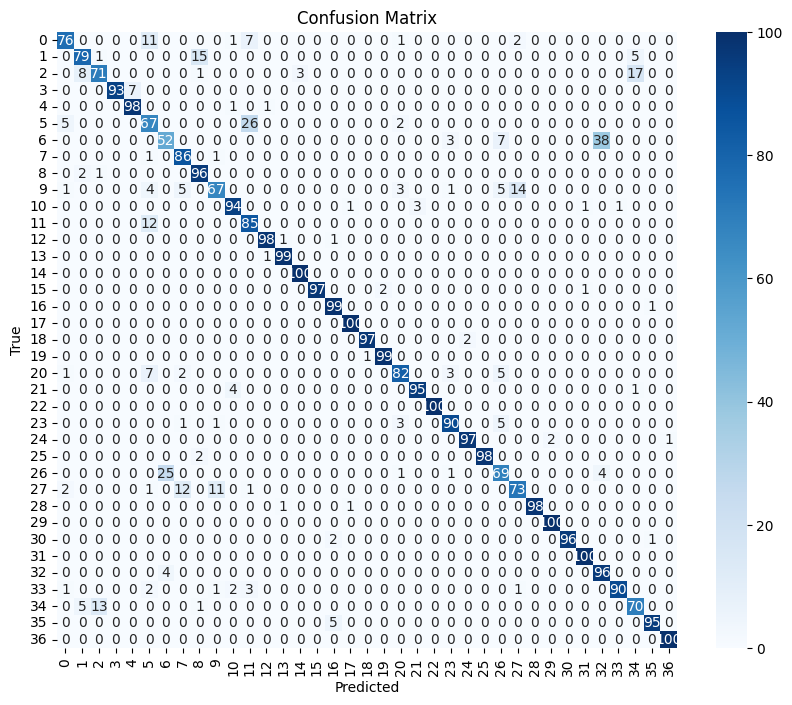

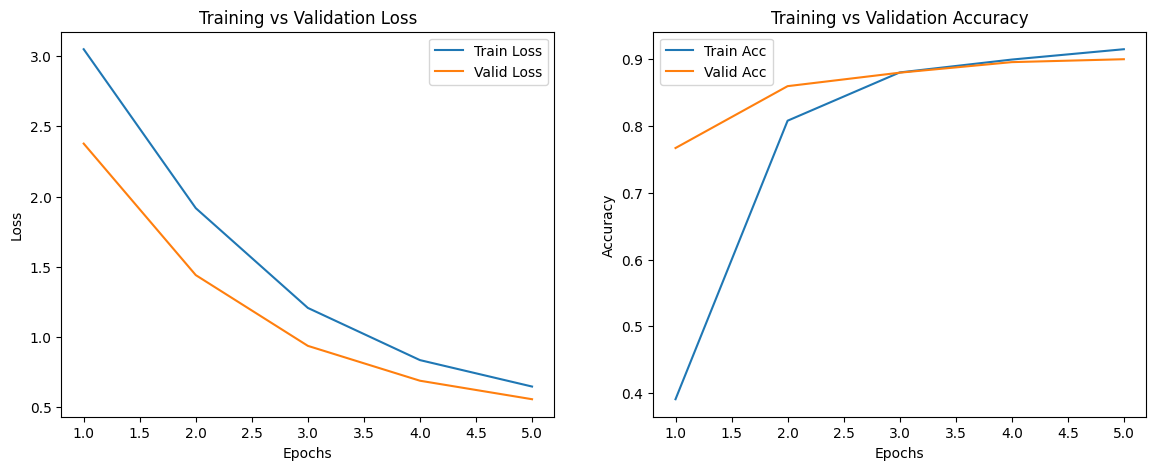


 Pipeline finished successfully!


In [ ]:
import torch
import pandas as pd

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load train/test splits
    train_file = "/content/trainval.txt"
    test_file  = "/content/test.txt"
    images_path = "/content/images/images/images/images"

    train_df = load_split(train_file)
    test_df = load_split(test_file)

    print("Train images:", len(train_df))
    print("Test images:", len(test_df))

    # Show some raw samples
    print("\n Showing raw samples...")
    show_samples(train_df, 5)

    # Preprocess
    print("\n Preprocessing for VGG (160x160)...")
    train_loader_vgg, valid_loader_vgg, num_classes = preprocess_images(
    train_df, test_df, images_path, img_size=160, aug_strength="medium")

    print("\n Preprocessing for ViT (224x224)...")
    train_loader_vit, valid_loader_vit, _ = preprocess_images(
    train_df, test_df, images_path, img_size=224, aug_strength="medium")

    # Show some augmented samples ----
    print("\n Showing augmented samples...")
    show_augmented_images(train_loader.dataset, n=6)

    # Train VGG model
    print("\n Training VGG model...")
    vgg_model, vgg_history = train_vgg_model(train_loader_vgg, valid_loader_vgg, num_classes, epochs=5, lr=1e-4, device=device)

    # Evaluate VGG
    print("\n Evaluating VGG model...")
    vgg_results = evaluate_model(vgg_model, valid_loader_vgg, history=vgg_history, device=device)

    # Train ViT model
    print("\n Training ViT model...")
    vit_model, vit_history = train_vit_model(train_loader_vit, valid_loader_vit, num_classes, epochs=5, lr=1e-4, device=device)

    # Evaluate ViT
    print("\n Evaluating ViT model...")
    vit_results = evaluate_model(vit_model, valid_loader_vit, history=vit_history, device=device)

    print("\n Pipeline finished successfully!")
    return {
        "vgg": vgg_results,
        "vit": vit_results
    }

if __name__ == "__main__":
    results = main()